In [2]:
# ============================
# Telco Customer Churn Prediction (Assignment 2)
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ----------------------------
# 1) Load Dataset
# ----------------------------
df = pd.read_csv("Telco-Customer-Churn.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# ----------------------------
# 2) Basic Data Checks
# ----------------------------
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())

# Check duplicates
print("\nDuplicate rows:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# ----------------------------
# 3) Fix TotalCharges (it sometimes contains spaces)
# ----------------------------
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Check missing after conversion
print("Missing TotalCharges after conversion:", df["TotalCharges"].isnull().sum())

# Drop missing rows (usually very few)
df = df.dropna()

print("New dataset shape after dropping missing:", df.shape)

Missing TotalCharges after conversion: 11
New dataset shape after dropping missing: (7032, 21)


Churn
No     5163
Yes    1869
Name: count, dtype: int64


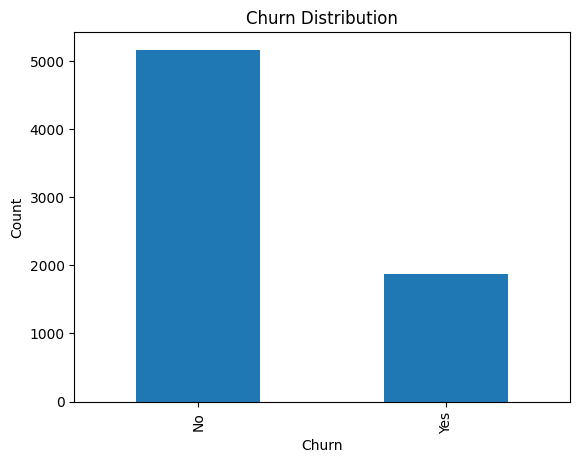

In [5]:
churn_counts = df["Churn"].value_counts()
print(churn_counts)

plt.figure()
churn_counts.plot(kind="bar")
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

Churn                 No       Yes
Contract                          
Month-to-month  0.572903  0.427097
One year        0.887228  0.112772
Two year        0.971513  0.028487


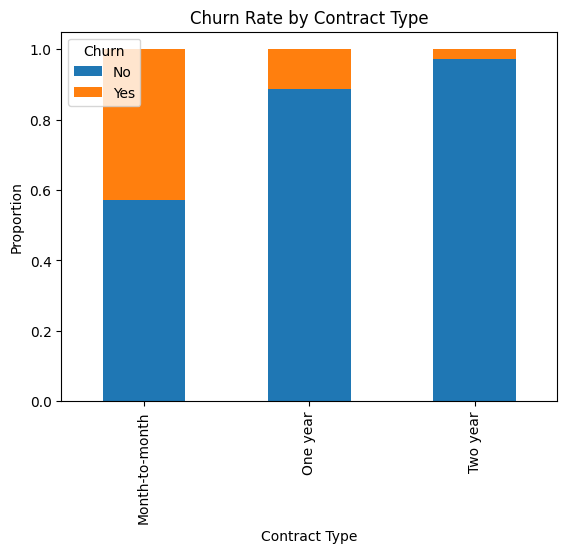

In [8]:
contract_churn = pd.crosstab(df["Contract"], df["Churn"], normalize="index")
print(contract_churn)

contract_churn.plot(kind="bar", stacked=True)
plt.title("Churn Rate by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Proportion")
plt.legend(title="Churn")
plt.show()

<Figure size 640x480 with 0 Axes>

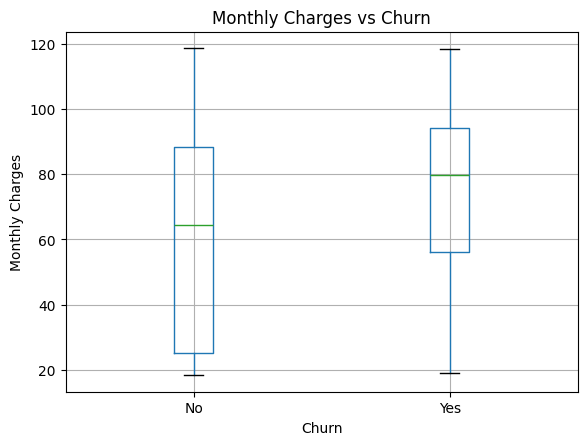

In [7]:
plt.figure()
df.boxplot(column="MonthlyCharges", by="Churn")
plt.title("Monthly Charges vs Churn")
plt.suptitle("")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.show()

<Figure size 640x480 with 0 Axes>

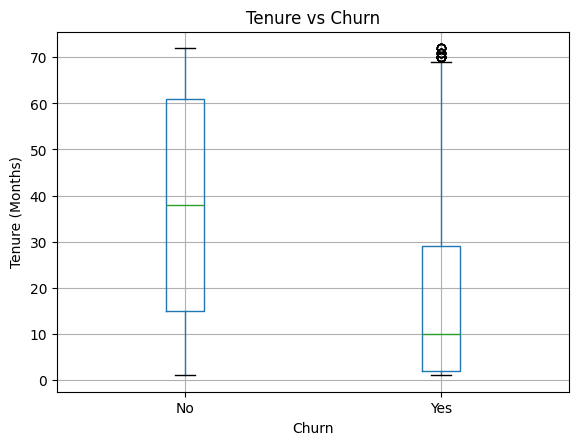

In [9]:
plt.figure()
df.boxplot(column="tenure", by="Churn")
plt.title("Tenure vs Churn")
plt.suptitle("")
plt.xlabel("Churn")
plt.ylabel("Tenure (Months)")
plt.show()

In [10]:
# ----------------------------
# 4) Drop CustomerID (not useful for prediction)
# ----------------------------
df = df.drop(columns=["customerID"])

# Convert target variable Churn (Yes/No -> 1/0)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Convert "SeniorCitizen" to categorical
df["SeniorCitizen"] = df["SeniorCitizen"].astype("category")

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)

print("Encoded dataset shape:", df_encoded.shape)
df_encoded.head()

Encoded dataset shape: (7032, 31)


,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,False,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,34,56.95,1889.50,0,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,2,53.85,108.15,1,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,45,42.30,1840.75,0,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,2,70.70,151.65,1,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [11]:
# ----------------------------
# 5) Train-Test Split
# ----------------------------
X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (5625, 30)
Test shape: (1407, 30)


In [12]:
# ----------------------------
# 6) Logistic Regression (with scaling)
# ----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(max_iter=2000)
log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall:", recall_score(y_test, y_pred_log))
print("F1-score:", f1_score(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Results
Accuracy: 0.8038379530916845
Precision: 0.6475903614457831
Recall: 0.5748663101604278
F1-score: 0.6090651558073654
ROC-AUC: 0.8356727976766699

Confusion Matrix:
 [[916 117]
 [159 215]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



In [13]:
# ----------------------------
# 7) Random Forest Classifier
# ----------------------------
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("✅ Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

✅ Random Forest Results
Accuracy: 0.7839374555792467
Precision: 0.6190476190476191
Recall: 0.48663101604278075
F1-score: 0.5449101796407185
ROC-AUC: 0.8194216523184121

Confusion Matrix:
 [[921 112]
 [192 182]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.78      1407



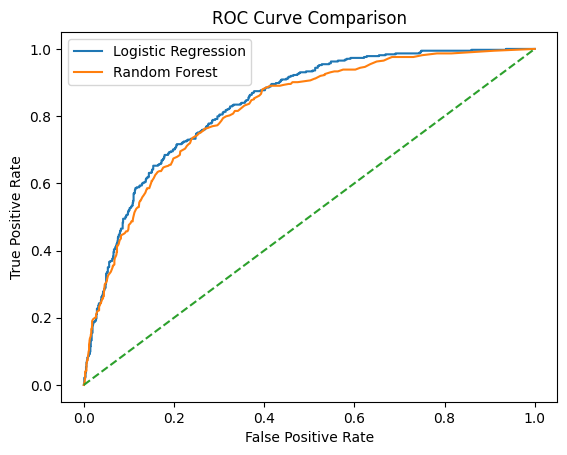

In [14]:
# ----------------------------
# 8) ROC Curve
# ----------------------------
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure()
plt.plot(fpr_log, tpr_log, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0, 1], [0, 1], linestyle="--")  # random baseline

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Top 15 Important Features:

TotalCharges                      0.188029
tenure                            0.177139
MonthlyCharges                    0.167394
PaymentMethod_Electronic check    0.038147
InternetService_Fiber optic       0.037045
Contract_Two year                 0.031752
gender_Male                       0.028756
OnlineSecurity_Yes                0.026317
PaperlessBilling_Yes              0.025868
Contract_One year                 0.024210
TechSupport_Yes                   0.023183
Partner_Yes                       0.022696
OnlineBackup_Yes                  0.022548
SeniorCitizen_1                   0.020701
Dependents_Yes                    0.020344
dtype: float64


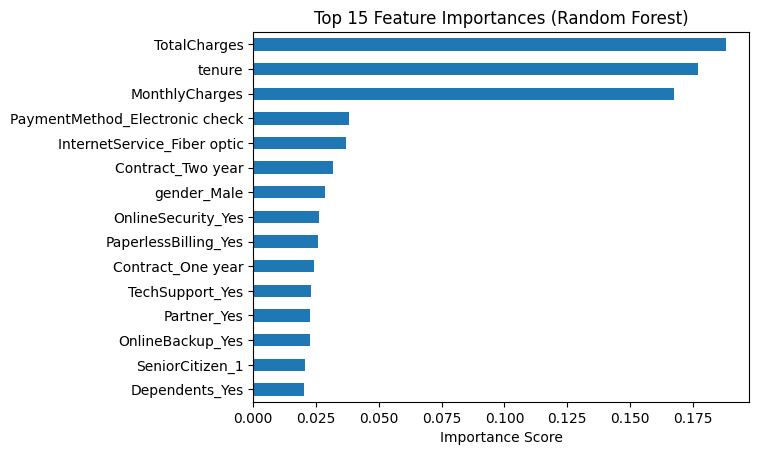

In [15]:
# ----------------------------
# 9) Feature Importance
# ----------------------------
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

print("Top 15 Important Features:\n")
print(top_features)

plt.figure()
top_features.sort_values().plot(kind="barh")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.show()